<a href="https://www.kaggle.com/code/elihat/fork-of-final-titanic-machine-learning-competition?scriptVersionId=285841013" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

In [3]:
# Load the dataset using pandas
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# New Features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

df['FareBin'] = pd.qcut(df['Fare'], 4, labels=['Low','Mid','High','VeryHigh'])

df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'the Countess'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss').replace('Ms', 'Miss').replace('Mme', 'Mrs')
df['Title'].value_counts()

df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median'))

In [5]:
# Convert categorical variables
categorical_variables = ['Sex', 'FareBin']
df = pd.get_dummies(data = df,
                         prefix = categorical_variables,
                         columns = categorical_variables)
df.head()




,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title,Sex_female,Sex_male,FareBin_Low,FareBin_Mid,FareBin_High,FareBin_VeryHigh
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,2,Mr,False,True,True,False,False,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,2,Mrs,True,False,False,False,False,True
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss,True,False,False,True,False,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,2,Mrs,True,False,False,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1,Mr,False,True,False,True,False,False


In [6]:
# Exclude features
df = df.drop(['PassengerId','Name','Ticket','Cabin', 'Embarked', 'Title'], axis=1)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,FareBin_Low,FareBin_Mid,FareBin_High,FareBin_VeryHigh
0,0,3,22.0,1,0,7.2500,2,False,True,True,False,False,False
1,1,1,38.0,1,0,71.2833,2,True,False,False,False,False,True
2,1,3,26.0,0,0,7.9250,1,True,False,False,True,False,False
3,1,1,35.0,1,0,53.1000,2,True,False,False,False,False,True
4,0,3,35.0,0,0,8.0500,1,False,True,False,True,False,False


<Axes: >

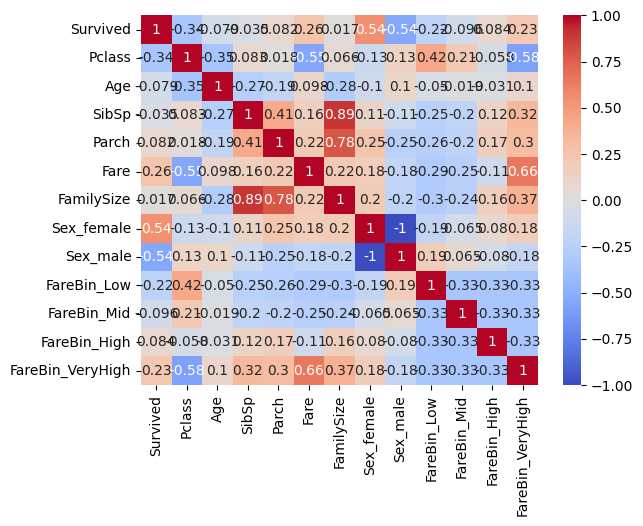

In [7]:
corrs = df.corr()
sns.heatmap(corrs, annot=True, cmap='coolwarm')

In [8]:
features = [x for x in df.columns if x not in 'Survived']
print(len(features))

12


In [9]:
# Split Data
X_train, X_val, y_train, y_val = train_test_split(df[features], df['Survived'], train_size = 0.8, random_state=50)
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 712
validation samples: 179
target proportion: 0.3708


## Clean the NaN values

In [10]:
imputer = SimpleImputer(strategy='mean')

X_train_clean = imputer.fit_transform(X_train)

X_val_clean = imputer.transform(X_val) 

## Random Forest Classifier

In [11]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'min_samples_split': [2, 10, 20, 50, 100],
    'max_depth': [None, 5,10, 15, 20],
    'n_estimators':[10,50,100,500]
}
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy',
                           return_train_score=True)


grid_search.fit(X_train_clean, y_train)

# Resultados
print("El mejor valor encontrado fue:", grid_search.best_params_)
print("La mejor precisión (accuracy) fue:", grid_search.best_score_)


El mejor valor encontrado fue: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
La mejor precisión (accuracy) fue: 0.8468334482418991


In [12]:
model_final_rf = RandomForestClassifier(n_estimators=100,
                                             class_weight='balanced',
                                             max_depth = 15, 
                                             min_samples_split = 10).fit(X_train_clean,y_train)

In [13]:
y_pred = model_final_rf.predict(X_val_clean)

In [14]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7988826815642458


## XGBoost Classifier

In [15]:
from xgboost import XGBClassifier
n = int(len(X_train_clean)*0.8)

In [16]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train_clean[:n], X_train_clean[n:], y_train[:n], y_train[n:]

In [17]:
xgb_model = XGBClassifier(n_estimators = 1000, learning_rate = 0.1,verbosity = 1, random_state = 42)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)

[0]	validation_0-logloss:0.61565
[1]	validation_0-logloss:0.58095
[2]	validation_0-logloss:0.55372
[3]	validation_0-logloss:0.53128
[4]	validation_0-logloss:0.51233
[5]	validation_0-logloss:0.49742
[6]	validation_0-logloss:0.48276
[7]	validation_0-logloss:0.47302
[8]	validation_0-logloss:0.46064
[9]	validation_0-logloss:0.45255
[10]	validation_0-logloss:0.44572
[11]	validation_0-logloss:0.43932
[12]	validation_0-logloss:0.43425
[13]	validation_0-logloss:0.43020
[14]	validation_0-logloss:0.42704
[15]	validation_0-logloss:0.42376
[16]	validation_0-logloss:0.42182
[17]	validation_0-logloss:0.41803
[18]	validation_0-logloss:0.41599
[19]	validation_0-logloss:0.41507
[20]	validation_0-logloss:0.41430
[21]	validation_0-logloss:0.41519
[22]	validation_0-logloss:0.41502
[23]	validation_0-logloss:0.41472
[24]	validation_0-logloss:0.41504
[25]	validation_0-logloss:0.41699
[26]	validation_0-logloss:0.41736
[27]	validation_0-logloss:0.41740
[28]	validation_0-logloss:0.41908
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [18]:
xgb_model.best_iteration

20

In [19]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val_clean),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8919
Metrics test:
	Accuracy score: 0.7989


## Neural Network

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_clean)
X_val_scaled = scaler.transform(X_val_clean) 


model_nn = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2), # Apaga el 20% de neuronas al azar para evitar memorizar (Overfitting)
    
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    
    layers.Dense(1, activation='sigmoid'),
])


model_nn.compile(
    optimizer='adam',             
    loss='binary_crossentropy',  
    metrics=['accuracy']
)


history = model_nn.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    batch_size=32,
    epochs=50,
    verbose=1 
)

2025-12-13 02:12:52.562445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765591972.803636      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765591972.872670      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/50


2025-12-13 02:13:09.751253: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4403 - loss: 0.7827 - val_accuracy: 0.6034 - val_loss: 0.6919
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6254 - loss: 0.6849 - val_accuracy: 0.6648 - val_loss: 0.6483
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6373 - loss: 0.6480 - val_accuracy: 0.7039 - val_loss: 0.6215
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6792 - loss: 0.6004 - val_accuracy: 0.7095 - val_loss: 0.6019
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7301 - loss: 0.5750 - val_accuracy: 0.7039 - val_loss: 0.5875
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6813 - loss: 0.5797 - val_accuracy: 0.7374 - val_loss: 0.5718
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7369 - loss: 0.5636 - val_accuracy: 0.7486 - val_loss: 0.5619
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7046 - loss: 0.5881 - val_accuracy: 0.7598 - val_loss: 0.5501
Ep

## CatBoost

In [21]:
import pandas as pd

test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

passenger_ids = test_df['PassengerId']


test_df = test_df.drop(['PassengerId','Name','Cabin', 'Embarked'], axis=1)


categorical_variables = ['Sex']
test_df = pd.get_dummies(data=test_df, prefix=categorical_variables, columns=categorical_variables)

test_df = test_df.reindex(columns = X_train.columns, fill_value=0)

features = X_train.columns
X_completo = pd.concat([X_train, X_val]) 
y_completo = pd.concat([y_train, y_val])

imputer_final = SimpleImputer(strategy='mean')
X_completo_clean = imputer_final.fit_transform(X_completo)


test_df_clean = imputer_final.transform(test_df)
test_df_scaled = scaler.transform(test_df_clean)

In [22]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(iterations=1000, 
                               random_seed=42, 
                               loss_function='Logloss',
                               verbose=0, 
                               allow_writing_files=False)
cat_model.fit(X_completo_clean, y_completo)

## Submission File

In [23]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
estimators = [
    ('rf', model_final_rf),
    ('xgb', xgb_model),
    ('cat', cat_model)
]
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stack_model.fit(X_completo_clean, y_completo)


prob_stack = stack_model.predict_proba(test_df_clean)[:,1]
prob_nn_test = model_nn.predict(test_df_scaled).reshape(-1)

prob_final = (prob_stack + prob_nn_test) / 2
predictions = (prob_final > 0.5).astype(int)


# Guardar
output = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})
output.to_csv('submission_blend_4x_final.csv', index=False)
print("¡Archivo submission_blend_4x_final.csv generado!")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
¡Archivo submission_blend_4x_final.csv generado!


Random Forest: Media = 0.8316 (+/- 0.0212)
XGBoost: Media = 0.8092 (+/- 0.0258)
CatBoost: Media = 0.8428 (+/- 0.0261)
Stacking: Media = 0.8440 (+/- 0.0170)


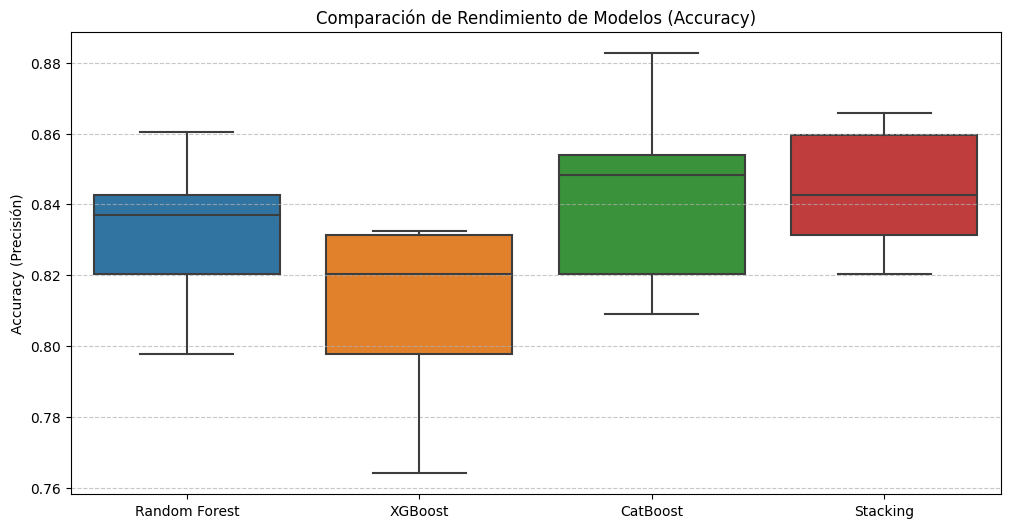

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold

modelos_a_comparar = [
    ('Random Forest', model_final_rf),
    ('XGBoost', xgb_model),
    ('CatBoost', cat_model),
    ('Stacking', stack_model) 
]

resultados = []
nombres = []


for nombre, modelo in modelos_a_comparar:

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
   
    cv_scores = cross_val_score(modelo, X_completo_clean, y_completo, cv=kfold, scoring='accuracy')
    
    resultados.append(cv_scores)
    nombres.append(nombre)
    
    print(f"{nombre}: Media = {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


plt.figure(figsize=(12, 6))
#  Boxplot
sns.boxplot(data=resultados)
plt.xticks(range(len(nombres)), nombres) 
plt.title('Comparación de Rendimiento de Modelos (Accuracy)')
plt.ylabel('Accuracy (Precisión)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()